### This project shows how to classify images of flowers. It creates an image classifier using a keras.Sequential model, and loads data using preprocessing.image_dataset_from_directory.

### Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing import image_dataset_from_directory



### Download and explore the dataset

### This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:
  flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [19]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


### Here are some dandelions

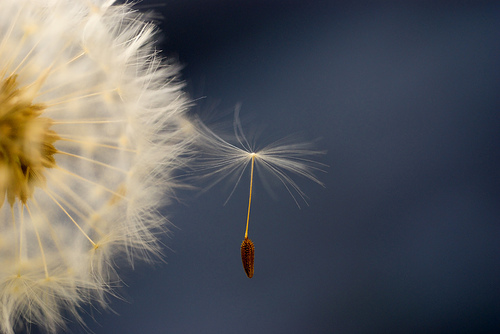

In [58]:
dandelion = list(data_dir.glob('dandelion/*'))
PIL.Image.open(str(dandelion[1]))

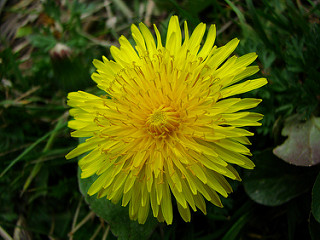

In [21]:
PIL.Image.open(str(dandelion[2]))

## Here are some roses:

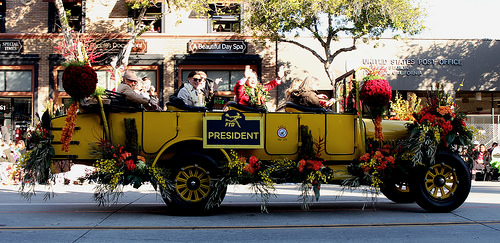

In [15]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

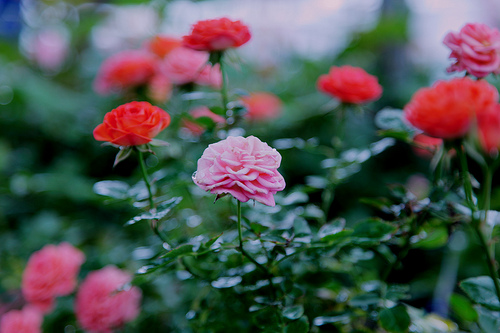

In [18]:
PIL.Image.open(str(roses[1]))

### Using keras.preprocessing
Create dataset


#### Define some parameters for the loader: 

In [22]:
batch_size = 32
img_height = 180
img_width = 180

###  It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [23]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [24]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [25]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


##  Visualize the data

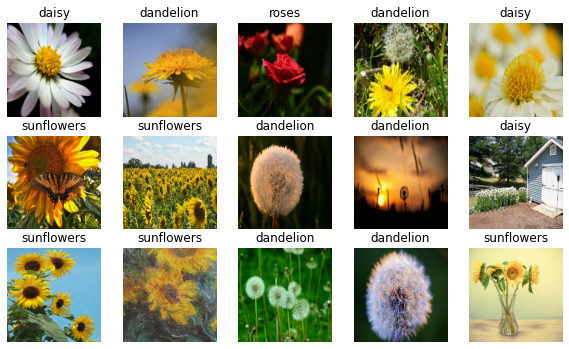

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Here are the first 15 images from the training dataset.

### You will train a model using these datasets by passing them to model.fit in a moment. 

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [30]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    

(32, 180, 180, 3)
(32,)


### Configure the dataset for performance

In [31]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

### Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer.

In [33]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [35]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Create the model
The model consist of three conv. blocks with a max pool layer in each of them. There is a fully connected layet with 128 units on top of it that is activated by a "relu" activation function. This model has not been tuned for high accuracy.

In [36]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# For this tutorial, choose the optimizers.
#Adam optimizer and losses.
#SparseCategoricalCrossentropy loss function. 
#To view training and validation accuracy for each training epoch, 
#pass the metrics argument.

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [42]:
epochs = 5 # change the 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs)

Epoch 1/5
92/92 [==============================] - 63s 681ms/step - loss: 1.2954 - accuracy: 0.4424 - val_loss: 1.0546 - val_accuracy: 0.5777
Epoch 2/5
92/92 [==============================] - 59s 637ms/step - loss: 0.9809 - accuracy: 0.6253 - val_loss: 1.0012 - val_accuracy: 0.5790
Epoch 3/5
92/92 [==============================] - 61s 662ms/step - loss: 0.7463 - accuracy: 0.7163 - val_loss: 0.9270 - val_accuracy: 0.6267
Epoch 4/5
92/92 [==============================] - 59s 642ms/step - loss: 0.5179 - accuracy: 0.8134 - val_loss: 1.1108 - val_accuracy: 0.6267
Epoch 5/5
92/92 [==============================] - 60s 648ms/step - loss: 0.3535 - accuracy: 0.8764 - val_loss: 1.3289 - val_accuracy: 0.5954


###  Data augmentation

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing. These can be included inside your model like other layers, and run on the GPU.


In [44]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

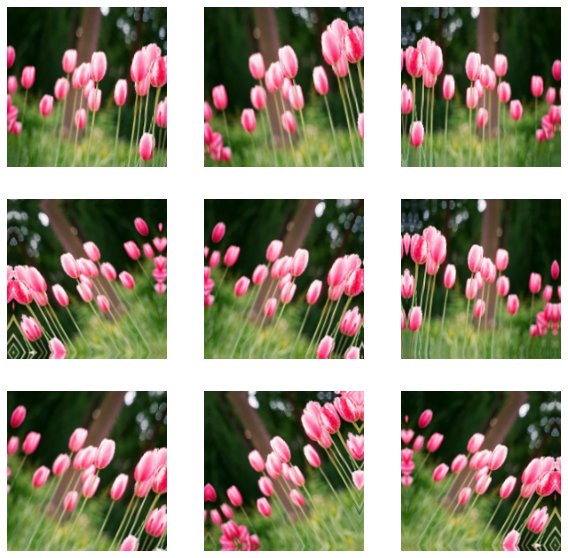

In [45]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Dropout

Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout, then train it using augmented images.




In [47]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [49]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [51]:
epochs = 5 #change to 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
# After applying data augmentation and Dropout, 
# there is less overfitting than before, 
# and training and validation accuracy are closer aligned.

Epoch 1/5
92/92 [==============================] - 80s 856ms/step - loss: 1.8813 - accuracy: 0.2649 - val_loss: 1.2536 - val_accuracy: 0.4959
Epoch 2/5
92/92 [==============================] - 66s 712ms/step - loss: 1.1854 - accuracy: 0.4962 - val_loss: 1.0723 - val_accuracy: 0.5790
Epoch 3/5
92/92 [==============================] - 63s 687ms/step - loss: 1.1027 - accuracy: 0.5520 - val_loss: 0.9877 - val_accuracy: 0.6117
Epoch 4/5
92/92 [==============================] - 64s 693ms/step - loss: 0.9691 - accuracy: 0.6082 - val_loss: 0.9819 - val_accuracy: 0.6294
Epoch 5/5
92/92 [==============================] - 64s 694ms/step - loss: 0.9258 - accuracy: 0.6354 - val_loss: 1.0794 - val_accuracy: 0.5899


## Predict on new data
let's use our model to classify an image that wasn't included in the training or validation sets.

In [59]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 56.02 percent confidence.
